<a href="https://colab.research.google.com/github/Pratik07223/AI-Based-Energy-Consumption-Forecasting-for-Smart-Grids/blob/main/aicte_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

def generate_synthetic_data():
    """Generate synthetic energy consumption data for smart grids"""

    # Date range
    date_range = pd.date_range(start='2022-01-01', end='2024-01-01', freq='H')
    n_samples = len(date_range)

    # Base consumption patterns
    data = []

    for i, date in enumerate(date_range):
        # Seasonal pattern
        day_of_year = date.dayofyear
        seasonal_factor = 1 + 0.3 * np.sin(2 * np.pi * day_of_year / 365.25)

        # Daily pattern
        hour = date.hour
        if 6 <= hour <= 9 or 17 <= hour <= 21:  # Peak hours
            daily_factor = 1.4
        elif 22 <= hour <= 23 or 0 <= hour <= 5:  # Off-peak
            daily_factor = 0.6
        else:  # Regular hours
            daily_factor = 1.0

        # Weekend effect
        is_weekend = date.weekday() >= 5
        weekend_factor = 0.8 if is_weekend else 1.0

        # Temperature effect
        temp_base = 15 + 10 * np.sin(2 * np.pi * day_of_year / 365.25)
        temperature = temp_base + np.random.normal(0, 3)
        temp_factor = 1 + 0.02 * abs(temperature - 20)  # AC/Heating effect

        # Holiday effect
        is_holiday = (date.month == 12 and date.day in [24, 25, 31]) or \
                    (date.month == 1 and date.day == 1) or \
                    (date.month == 7 and date.day == 4) or \
                    (date.month == 11 and date.day in [23, 24])
        holiday_factor = 0.7 if is_holiday else 1.0

        # Economic activity index
        economic_activity = 1.0 + 0.2 * np.sin(2 * np.pi * i / (365.25 * 24)) + np.random.normal(0, 0.1)
        economic_activity = max(0.5, min(1.5, economic_activity))

        # Renewable energy contribution (higher in summer/windy periods)
        renewable_base = 30 + 20 * np.sin(2 * np.pi * day_of_year / 365.25)
        renewable_contribution = renewable_base + np.random.normal(0, 10)
        renewable_contribution = max(0, min(80, renewable_contribution))

        # Base energy consumption calculation
        base_consumption = 3500  # Base kWh

        energy_consumption = base_consumption * seasonal_factor * daily_factor * \
                           weekend_factor * temp_factor * holiday_factor * \
                           (economic_activity / 1.0) + np.random.normal(0, 200)

        # Ensure realistic bounds
        energy_consumption = max(1500, min(7500, energy_consumption))

        # Season mapping
        if date.month in [12, 1, 2]:
            season = 'Winter'
        elif date.month in [3, 4, 5]:
            season = 'Spring'
        elif date.month in [6, 7, 8]:
            season = 'Summer'
        else:
            season = 'Fall'

        # Day type
        if is_holiday:
            day_type = 'Holiday'
        elif is_weekend:
            day_type = 'Weekend'
        else:
            day_type = 'Weekday'

        data.append({
            'Date': date,
            'Energy_Consumption': round(energy_consumption, 2),
            'Temperature': round(temperature, 1),
            'Day_Type': day_type,
            'Month': date.month,
            'Hour': date.hour,
            'Season': season,
            'Renewable_Energy_Contribution': round(renewable_contribution, 1),
            'Holiday_Flag': 1 if is_holiday else 0,
            'Economic_Activity_Index': round(economic_activity, 2)
        })

    return pd.DataFrame(data)

# Generate the dataset
df = generate_synthetic_data()
print("Dataset generated successfully!")
print(f"Shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())

# Save dataset
df.to_csv('energy_consumption_data.csv', index=False)
print("\nDataset saved as 'energy_consumption_data.csv'")

Dataset generated successfully!
Shape: (17521, 10)

First few rows:
                 Date  Energy_Consumption  Temperature Day_Type  Month  Hour  \
0 2022-01-01 00:00:00             1548.15         16.7  Holiday      1     0   
1 2022-01-01 01:00:00             1500.00         14.5  Holiday      1     1   
2 2022-01-01 02:00:00             1500.00         13.8  Holiday      1     2   
3 2022-01-01 03:00:00             1500.00         15.9  Holiday      1     3   
4 2022-01-01 04:00:00             1500.00         12.1  Holiday      1     4   

   Season  Renewable_Energy_Contribution  Holiday_Flag  \
0  Winter                           36.8             1   
1  Winter                           46.1             1   
2  Winter                           25.7             1   
3  Winter                           13.1             1   
4  Winter                           21.3             1   

   Economic_Activity_Index  
0                     0.99  
1                     0.98  
2              

In [ ]:
def perform_eda(df):
    """Perform comprehensive exploratory data analysis"""

    print("=== EXPLORATORY DATA ANALYSIS ===\n")

    # Basic statistics
    print("Dataset Info:")
    print(f"Shape: {df.shape}")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")

    # Missing values
    print(f"\nMissing values:\n{df.isnull().sum()}")

    # Statistical summary
    print(f"\nStatistical Summary:")
    print(df.describe())

    # Energy consumption patterns
    print(f"\nEnergy Consumption Patterns:")
    print(f"Average daily consumption: {df.groupby(df['Date'].dt.date)['Energy_Consumption'].sum().mean():.0f} kWh")
    print(f"Peak consumption: {df['Energy_Consumption'].max():.0f} kWh")
    print(f"Minimum consumption: {df['Energy_Consumption'].min():.0f} kWh")

    return df

# Perform EDA
df_analyzed = perform_eda(df)

=== EXPLORATORY DATA ANALYSIS ===

Dataset Info:
Shape: (17521, 10)
Memory usage: 2.92 MB
Date range: 2022-01-01 00:00:00 to 2024-01-01 00:00:00

Missing values:
Date                             0
Energy_Consumption               0
Temperature                      0
Day_Type                         0
Month                            0
Hour                             0
Season                           0
Renewable_Energy_Contribution    0
Holiday_Flag                     0
Economic_Activity_Index          0
dtype: int64

Statistical Summary:
                      Date  Energy_Consumption   Temperature         Month  \
count                17521        17521.000000  17521.000000  17521.000000   
mean   2023-01-01 00:00:00         3830.024625     15.012328      6.525712   
min    2022-01-01 00:00:00         1500.000000     -4.200000      1.000000   
25%    2022-07-02 12:00:00         2446.630000      8.300000      4.000000   
50%    2023-01-01 00:00:00         3470.280000     15.000000   

In [ ]:
def engineer_features(df):
    """Create additional features for better model performance"""

    df_featured = df.copy()

    # Time-based features
    df_featured['Year'] = df_featured['Date'].dt.year
    df_featured['Week'] = df_featured['Date'].dt.isocalendar().week
    df_featured['DayOfWeek'] = df_featured['Date'].dt.dayofweek
    df_featured['DayOfYear'] = df_featured['Date'].dt.dayofyear

    # Cyclical encoding for time features
    df_featured['Hour_sin'] = np.sin(2 * np.pi * df_featured['Hour'] / 24)
    df_featured['Hour_cos'] = np.cos(2 * np.pi * df_featured['Hour'] / 24)
    df_featured['Month_sin'] = np.sin(2 * np.pi * df_featured['Month'] / 12)
    df_featured['Month_cos'] = np.cos(2 * np.pi * df_featured['Month'] / 12)
    df_featured['DayOfWeek_sin'] = np.sin(2 * np.pi * df_featured['DayOfWeek'] / 7)
    df_featured['DayOfWeek_cos'] = np.cos(2 * np.pi * df_featured['DayOfWeek'] / 7)

    # Sort by date for lag features
    df_featured = df_featured.sort_values('Date').reset_index(drop=True)

    # Lag features
    for lag in [1, 2, 7, 24]:  # 1h, 2h, 7h, 24h lags
        df_featured[f'Energy_Lag_{lag}'] = df_featured['Energy_Consumption'].shift(lag)

    # Rolling statistics
    for window in [7, 24, 168]:  # 7h, 24h, 168h (1 week) windows
        df_featured[f'Energy_Rolling_Mean_{window}'] = df_featured['Energy_Consumption'].rolling(window=window).mean()
        df_featured[f'Energy_Rolling_Std_{window}'] = df_featured['Energy_Consumption'].rolling(window=window).std()

    # Temperature-based features
    df_featured['Temp_Squared'] = df_featured['Temperature'] ** 2
    df_featured['Cooling_Degree_Days'] = np.maximum(df_featured['Temperature'] - 18, 0)
    df_featured['Heating_Degree_Days'] = np.maximum(18 - df_featured['Temperature'], 0)

    # Interaction features
    df_featured['Temp_Hour_Interaction'] = df_featured['Temperature'] * df_featured['Hour']
    df_featured['Renewable_Economic_Interaction'] = df_featured['Renewable_Energy_Contribution'] * df_featured['Economic_Activity_Index']

    # Remove rows with NaN values (due to lag and rolling features)
    df_featured = df_featured.dropna().reset_index(drop=True)

    print(f"Feature engineering complete. New shape: {df_featured.shape}")
    return df_featured

# Apply feature engineering
df_engineered = engineer_features(df)

Feature engineering complete. New shape: (17354, 35)


In [ ]:
def prepare_data_for_models(df):
    """Prepare data for machine learning and deep learning models"""

    # Define features and target
    target_col = 'Energy_Consumption'

    # Exclude non-feature columns
    exclude_cols = ['Date', 'Day_Type', 'Season']  # Will be encoded separately
    feature_cols = [col for col in df.columns if col not in exclude_cols + [target_col]]

    # One-hot encode categorical variables
    df_encoded = df.copy()
    df_encoded = pd.get_dummies(df_encoded, columns=['Day_Type', 'Season'], prefix=['DayType', 'Season'])

    # Update feature columns after encoding
    feature_cols = [col for col in df_encoded.columns if col not in ['Date', target_col]]

    X = df_encoded[feature_cols]
    y = df_encoded[target_col]

    return X, y, feature_cols

# Prepare data
X, y, feature_names = prepare_data_for_models(df_engineered)

# Split data chronologically
split_idx = int(0.8 * len(X))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# Scale features for neural networks
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

Training set shape: (13883, 38)
Test set shape: (3471, 38)


In [ ]:
def train_ml_models(X_train, y_train, X_test, y_test):
    """Train and evaluate machine learning models"""

    models = {}
    predictions = {}
    metrics = {}

    # 1. Linear Regression (Baseline)
    print("Training Linear Regression...")
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    lr_pred = lr.predict(X_test)

    models['Linear_Regression'] = lr
    predictions['Linear_Regression'] = lr_pred

    # 2. Random Forest
    print("Training Random Forest...")
    rf_params = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }

    rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    rf_grid = GridSearchCV(rf, rf_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    rf_grid.fit(X_train, y_train)

    rf_best = rf_grid.best_estimator_
    rf_pred = rf_best.predict(X_test)

    models['Random_Forest'] = rf_best
    predictions['Random_Forest'] = rf_pred

    print(f"Best RF params: {rf_grid.best_params_}")

    # Calculate metrics for all models
    for name, pred in predictions.items():
        rmse = np.sqrt(mean_squared_error(y_test, pred))
        mae = mean_absolute_error(y_test, pred)
        r2 = r2_score(y_test, pred)

        metrics[name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}

        print(f"\n{name} Results:")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAE: {mae:.2f}")
        print(f"R²: {r2:.4f}")

    return models, predictions, metrics

# Train ML models
ml_models, ml_predictions, ml_metrics = train_ml_models(X_train, y_train, X_test, y_test)

Training Linear Regression...
Training Random Forest...
Best RF params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Linear_Regression Results:
RMSE: 484.07
MAE: 383.96
R²: 0.7885

Random_Forest Results:
RMSE: 274.79
MAE: 202.51
R²: 0.9318


In [ ]:
def create_lstm_sequences(X, y, time_steps=24):
    """Create sequences for LSTM training"""

    X_seq, y_seq = [], []

    for i in range(time_steps, len(X)):
        X_seq.append(X[i-time_steps:i])
        y_seq.append(y[i])

    return np.array(X_seq), np.array(y_seq)

def build_lstm_model(input_shape):
    """Build and compile LSTM model"""

    model = Sequential([
        LSTM(100, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(25),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    return model

def train_lstm_model(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled):
    """Train LSTM model with proper sequence preparation"""

    print("Preparing sequences for LSTM...")

    # Create sequences
    time_steps = 24  # Use last 24 hours to predict next hour

    X_train_seq, y_train_seq = create_lstm_sequences(X_train_scaled, y_train_scaled, time_steps)
    X_test_seq, y_test_seq = create_lstm_sequences(X_test_scaled, y_test_scaled, time_steps)

    print(f"LSTM training sequences shape: {X_train_seq.shape}")
    print(f"LSTM test sequences shape: {X_test_seq.shape}")

    # Build model
    model = build_lstm_model((time_steps, X_train_scaled.shape[1]))
    print(f"LSTM Model built with input shape: {X_train_seq.shape[1:]}")

    # Train model
    print("Training LSTM model...")

    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5)
    ]

    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_test_seq, y_test_seq),
        epochs=100,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )

    # Make predictions
    lstm_pred_scaled = model.predict(X_test_seq)

    # Inverse transform predictions
    lstm_pred = scaler_y.inverse_transform(lstm_pred_scaled.reshape(-1, 1)).ravel()
    y_test_lstm = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).ravel()

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test_lstm, lstm_pred))
    mae = mean_absolute_error(y_test_lstm, lstm_pred)
    r2 = r2_score(y_test_lstm, lstm_pred)

    print(f"\nLSTM Results:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.4f}")

    return model, lstm_pred, y_test_lstm, history, {'RMSE': rmse, 'MAE': mae, 'R2': r2}

# Train LSTM model
lstm_model, lstm_pred, y_test_lstm, training_history, lstm_metrics = train_lstm_model(
    X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled
)

Preparing sequences for LSTM...
LSTM training sequences shape: (13859, 24, 38)
LSTM test sequences shape: (3447, 24, 38)
LSTM Model built with input shape: (24, 38)
Training LSTM model...
Epoch 1/100
434/434 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - loss: 0.3988 - mae: 0.5040 - val_loss: 0.0938 - val_mae: 0.2354 - learning_rate: 0.0010
Epoch 2/100
434/434 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - loss: 0.1520 - mae: 0.3007 - val_loss: 0.0831 - val_mae: 0.2150 - learning_rate: 0.0010
Epoch 3/100
434/434 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - loss: 0.1220 - mae: 0.2684 - val_loss: 0.0689 - val_mae: 0.2004 - learning_rate: 0.0010
Epoch 4/100
434/434 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - loss: 0.1084 - mae: 0.2567 - val_loss: 0.0680 - val_mae: 0.2027 - learning_rate: 0.0010
Epoch 5/100
434/434 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - loss: 0.1043 - mae: 0.2494 - val_loss: 0.0692 - val_mae: 0.2038 - learning_rate: 0.0010
Epoch 6/100
434/434 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - loss: 0.1005 - mae: 0.2445 - v

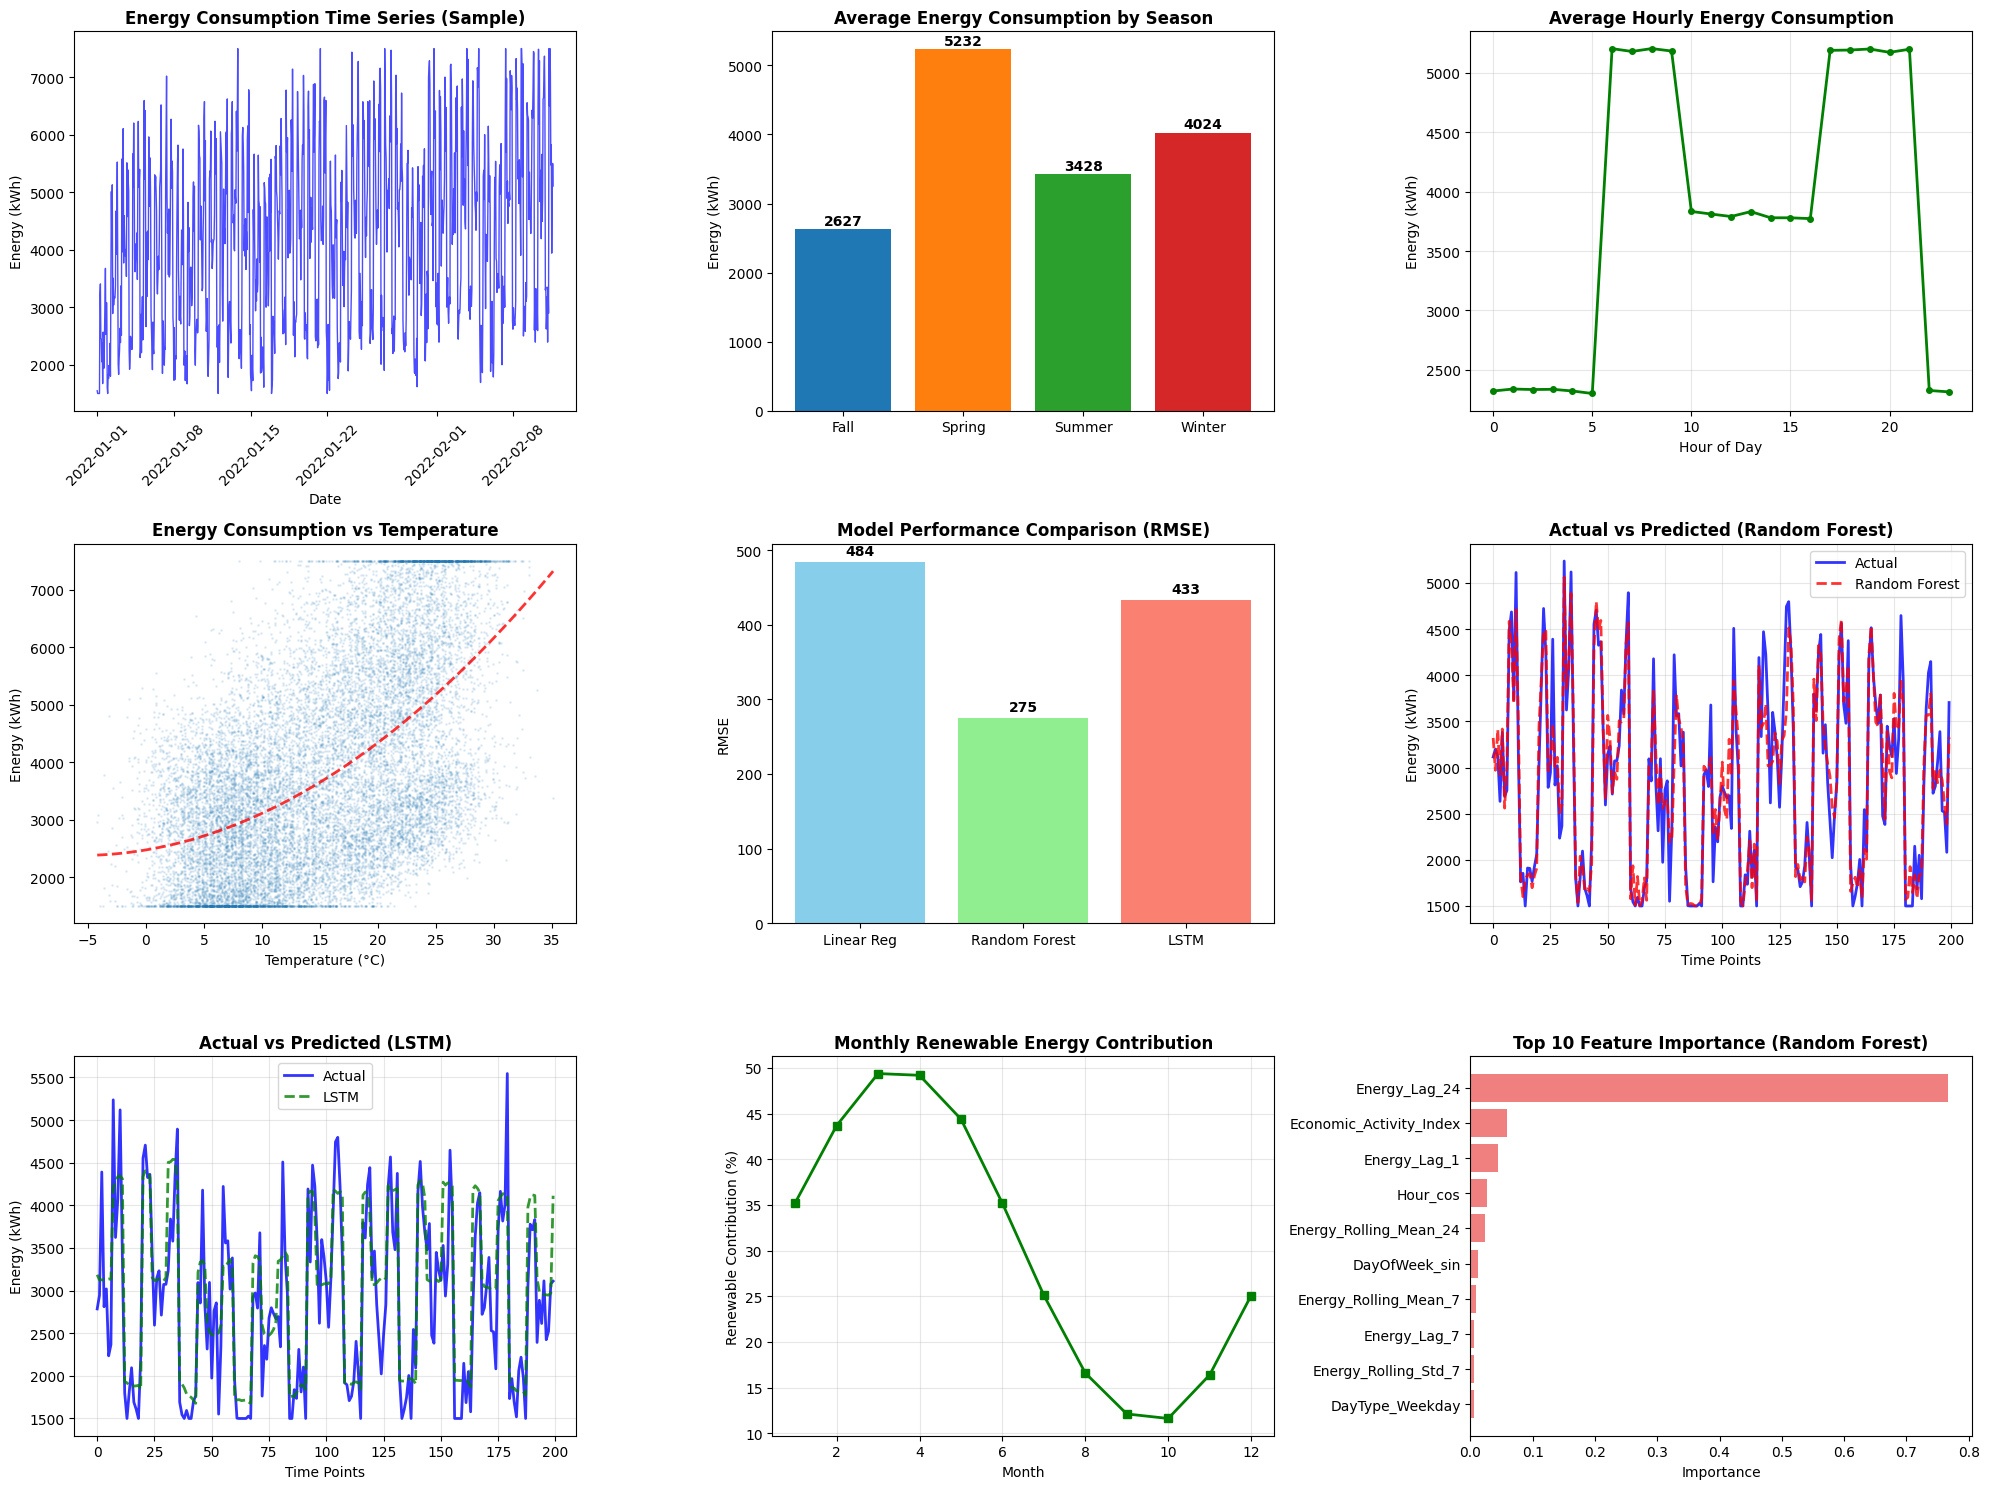

In [ ]:
def create_comprehensive_visualizations():
    """Create comprehensive result visualizations"""

    # Set up the plotting style
    plt.style.use('default')
    fig = plt.figure(figsize=(20, 15))

    # 1. Energy consumption time series
    ax1 = plt.subplot(3, 3, 1)
    plt.plot(df['Date'][:1000], df['Energy_Consumption'][:1000], 'b-', alpha=0.7, linewidth=1)
    plt.title('Energy Consumption Time Series (Sample)', fontsize=12, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Energy (kWh)')
    plt.xticks(rotation=45)

    # 2. Seasonal patterns
    ax2 = plt.subplot(3, 3, 2)
    seasonal_avg = df.groupby('Season')['Energy_Consumption'].mean()
    bars = plt.bar(seasonal_avg.index, seasonal_avg.values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    plt.title('Average Energy Consumption by Season', fontsize=12, fontweight='bold')
    plt.ylabel('Energy (kWh)')
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 20, f'{height:.0f}',
                ha='center', va='bottom', fontweight='bold')

    # 3. Hourly patterns
    ax3 = plt.subplot(3, 3, 3)
    hourly_avg = df.groupby('Hour')['Energy_Consumption'].mean()
    plt.plot(hourly_avg.index, hourly_avg.values, 'g-', marker='o', linewidth=2, markersize=4)
    plt.title('Average Hourly Energy Consumption', fontsize=12, fontweight='bold')
    plt.xlabel('Hour of Day')
    plt.ylabel('Energy (kWh)')
    plt.grid(True, alpha=0.3)

    # 4. Temperature vs Energy correlation
    ax4 = plt.subplot(3, 3, 4)
    plt.scatter(df['Temperature'], df['Energy_Consumption'], alpha=0.1, s=1)
    plt.title('Energy Consumption vs Temperature', fontsize=12, fontweight='bold')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Energy (kWh)')

    # Add trend line
    z = np.polyfit(df['Temperature'], df['Energy_Consumption'], 2)
    p = np.poly1d(z)
    temp_range = np.linspace(df['Temperature'].min(), df['Temperature'].max(), 100)
    plt.plot(temp_range, p(temp_range), "r--", alpha=0.8, linewidth=2)

    # 5. Model comparison - Performance metrics
    ax5 = plt.subplot(3, 3, 5)
    models = ['Linear Reg', 'Random Forest', 'LSTM']
    rmse_values = [ml_metrics['Linear_Regression']['RMSE'],
                   ml_metrics['Random_Forest']['RMSE'],
                   lstm_metrics['RMSE']]

    bars = plt.bar(models, rmse_values, color=['skyblue', 'lightgreen', 'salmon'])
    plt.title('Model Performance Comparison (RMSE)', fontsize=12, fontweight='bold')
    plt.ylabel('RMSE')

    for bar, value in zip(bars, rmse_values):
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 5,
                f'{value:.0f}', ha='center', va='bottom', fontweight='bold')

    # 6. Actual vs Predicted (Random Forest)
    ax6 = plt.subplot(3, 3, 6)
    sample_size = 200
    plt.plot(range(sample_size), y_test.iloc[:sample_size], 'b-', label='Actual', linewidth=2, alpha=0.8)
    plt.plot(range(sample_size), ml_predictions['Random_Forest'][:sample_size], 'r--',
             label='Random Forest', linewidth=2, alpha=0.8)
    plt.title('Actual vs Predicted (Random Forest)', fontsize=12, fontweight='bold')
    plt.xlabel('Time Points')
    plt.ylabel('Energy (kWh)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 7. Actual vs Predicted (LSTM)
    ax7 = plt.subplot(3, 3, 7)
    lstm_sample_size = min(200, len(lstm_pred))
    plt.plot(range(lstm_sample_size), y_test_lstm[:lstm_sample_size], 'b-',
             label='Actual', linewidth=2, alpha=0.8)
    plt.plot(range(lstm_sample_size), lstm_pred[:lstm_sample_size], 'g--',
             label='LSTM', linewidth=2, alpha=0.8)
    plt.title('Actual vs Predicted (LSTM)', fontsize=12, fontweight='bold')
    plt.xlabel('Time Points')
    plt.ylabel('Energy (kWh)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 8. Renewable energy contribution
    ax8 = plt.subplot(3, 3, 8)
    monthly_renewable = df.groupby('Month')['Renewable_Energy_Contribution'].mean()
    plt.plot(monthly_renewable.index, monthly_renewable.values, 'g-', marker='s',
             linewidth=2, markersize=6)
    plt.title('Monthly Renewable Energy Contribution', fontsize=12, fontweight='bold')
    plt.xlabel('Month')
    plt.ylabel('Renewable Contribution (%)')
    plt.grid(True, alpha=0.3)

    # 9. Feature importance (Random Forest)
    ax9 = plt.subplot(3, 3, 9)
    feature_importance = ml_models['Random_Forest'].feature_importances_
    top_features_idx = np.argsort(feature_importance)[-10:]
    top_features = [feature_names[i] for i in top_features_idx]
    top_importance = feature_importance[top_features_idx]

    plt.barh(range(len(top_features)), top_importance, color='lightcoral')
    plt.yticks(range(len(top_features)), top_features)
    plt.title('Top 10 Feature Importance (Random Forest)', fontsize=12, fontweight='bold')
    plt.xlabel('Importance')

    plt.tight_layout()
    plt.savefig('energy_forecasting_results.png', dpi=300, bbox_inches='tight')
    plt.show()

    return fig

# Create visualizations
results_figure = create_comprehensive_visualizations()